[Labeling Functions](#scrollTo=bmSjXBZytTT2)

[Coverage of Labeling Functions](#scrollTo=BTU_0Ukctaqr)

[Modeling](#scrollTo=-LCBexTYt-ik)

[On Faker Data](#scrollTo=wtyxKctNDpy1)

In [2]:
pip install snorkel

     |████████████████████████████████| 103 kB 4.2 MB/s 
     |████████████████████████████████| 22.3 MB 58.6 MB/s 
     |████████████████████████████████| 14.8 MB 37.2 MB/s 
     |████████████████████████████████| 5.6 MB 39.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, w

In [ ]:
pip install recordlinkage

     |████████████████████████████████| 926 kB 4.8 MB/s 
     |████████████████████████████████| 132 kB 55.9 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=74005 sha256=da756f31fa55f597eb8f3bf5a1c7f9d26d0e802b66470cae55d4579613f118c2
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built jellyfish


In [ ]:
import recordlinkage
import pandas as pd

In [ ]:
from recordlinkage.datasets import load_febrl4

In [ ]:
dfA, dfB, true_links = load_febrl4(return_links=True)
from recordlinkage.preprocessing import phonetic
dfA["phonetic_given_name"] = phonetic(dfA["given_name"], "soundex")
dfB["phonetic_given_name"] = phonetic(dfB["given_name"], "soundex")
dfA["phonetic_surname"] = phonetic(dfA["surname"], "soundex")
dfB["phonetic_surname"] = phonetic(dfB["surname"], "soundex")
dfA["initials"] = (dfA["given_name"].str[0]  + dfA["surname"].str[0])
dfB["initials"] = (dfB["given_name"].str[0]  + dfB["surname"].str[0])

dfA["date_of_birth"] = dfA["date_of_birth"].str.replace('-', "")
dfB["date_of_birth"] = dfB["date_of_birth"].str.replace('-', "")
dfA["soc_sec_id"] = dfA["soc_sec_id"].str.replace('-', "")
dfB["soc_sec_id"] = dfB["soc_sec_id"].str.replace('-', "")

dfA['address']=dfA['street_number']+" "+dfA['address_1']+" "+dfA['address_2']
dfB['address']=dfB['street_number']+" "+dfB['address_1']+" "+dfB['address_2']

In [ ]:
from recordlinkage import Compare
def data1(dfA,dfB,blocker=""):
  indexer = recordlinkage.Index()
  if blocker!="":
    indexer.block(blocker)
    candidate_links = indexer.index(dfA, dfB)
  else:
    a=list(dfA.index)
    b=list(dfB.index)
    candidate_links=pd.MultiIndex.from_product([a,b])  
  compare = Compare()
  compare.exact('phonetic_given_name', 'phonetic_given_name', label="phonetic_given_name")
  compare.exact('phonetic_surname', 'phonetic_surname', label='phonetic_surname')
  compare.string('given_name', 'given_name', method='jarowinkler', label="given_name")
  compare.string('surname', 'surname', method='jarowinkler', label="surname")
  compare.string('suburb', 'suburb', method='cosine', label="suburb")
  compare.string('state', 'state', method='cosine', label="state")
  compare.string('address', 'address', method='cosine', label="address")
  compare.string("soc_sec_id","soc_sec_id",method='cosine', label="soc_sec_id")
  compare.string("date_of_birth","date_of_birth",method='cosine', label="date_of_birth")
  features = compare.compute(candidate_links, dfA, dfB)
  return features

In [ ]:
features=data1(dfA,dfB,"initials")
features['Target']=features.index.isin(true_links)
features['Target']=features['Target'].astype(int)

data=features
df = data.sample(frac=1)
x_train=df.head(int(len(df)*0.8))
x_test=df.tail(int(len(df)*0.2))

In [ ]:
x_train.head()

,,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address,soc_sec_id,date_of_birth,Target
rec_id_1,rec_id_2,,,,,,,,,,
rec-377-org,rec-229-dup-0,0,0,0.492063,0.533333,0.000000,0.0,0.062500,0.125000,0.222222,0
rec-1597-org,rec-3682-dup-0,0,0,0.511111,0.555556,0.000000,0.0,0.000000,0.125000,0.501745,0
rec-124-org,rec-455-dup-0,0,0,0.527778,0.513889,0.204124,0.0,0.108866,0.102062,0.222222,0
rec-2137-org,rec-672-dup-0,0,0,0.625000,0.472222,0.000000,0.0,0.436308,0.250000,0.333333,0
rec-4522-org,rec-3511-dup-0,0,0,0.730000,0.527778,0.000000,0.0,0.152641,0.000000,0.333333,0


In [ ]:
NOMATCH = 0
UNKNOWN = -1
MATCH = 1



<a id=l></a>
#Labeling Functions

In [ ]:
from snorkel.labeling import labeling_function

@labeling_function()
def soc_sec(x):
    return MATCH if x.soc_sec_id>0.9 else UNKNOWN
@labeling_function()    
def soc_sec_rev(x):
    return NOMATCH if x.soc_sec_id<0.6 else UNKNOWN


@labeling_function()
def name(x):
    return MATCH if  x.given_name>0.9 and x.surname>0.9 else UNKNOWN

@labeling_function()
def name_date(x):
    return MATCH if  x.given_name>0.9 and x.surname>0.9 and x.date_of_birth>0.7 else UNKNOWN

@labeling_function()
def name_rev(x):
    return NOMATCH if  x.given_name<0.6 or x.surname<0.6 else UNKNOWN    

@labeling_function()
def address(x):
    return MATCH if  x.address>0.6 else UNKNOWN

@labeling_function()
def address_rev(x):
    return NOMATCH if  x.address<0.2 else UNKNOWN    

In [ ]:
from snorkel.labeling import PandasLFApplier

lfs = [soc_sec, address,soc_sec_rev, name_rev, address_rev,name_date]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=x_train)

100%|██████████| 82808/82808 [00:08<00:00, 9759.25it/s] 


In [ ]:
L_train[:10]

array([[-1, -1,  0,  0,  0, -1],
       [-1, -1,  0,  0,  0, -1],
       [-1, -1,  0,  0,  0, -1],
       [-1, -1,  0,  0, -1, -1],
       [-1, -1,  0,  0,  0, -1],
       [-1, -1,  0,  0,  0, -1],
       [-1, -1,  0, -1,  0, -1],
       [-1, -1,  0, -1, -1, -1],
       [-1, -1,  0,  0, -1, -1],
       [-1, -1,  0, -1,  0, -1]])

<a id=#c></a>
# Coverage of Labeling Functions

In [ ]:
coverage_soc_sec,  coverage_address,coverage_soc_sec_rev, coverage_name_rev, coverage_address_rev,coverage_name_date = (L_train != UNKNOWN).mean(axis=0)
print(f"soc_sec coverage: {coverage_soc_sec * 100:.1f}%")
#print(f"name coverage: {coverage_name * 100:.1f}%")
print(f"address coverage: {coverage_address * 100:.1f}%")
print(f"soc_sec_rev coverage: {coverage_soc_sec_rev * 100:.1f}%")
print(f"name_rev coverage: {coverage_name_rev * 100:.1f}%")
print(f"address_rev coverage: {coverage_address_rev * 100:.1f}%")
print(f"name_date coverage: {coverage_name_date * 100:.1f}%")

soc_sec coverage: 3.3%
address coverage: 2.6%
soc_sec_rev coverage: 96.5%
name_rev coverage: 78.2%
address_rev coverage: 66.5%
name_date coverage: 3.1%


In [ ]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
soc_sec,0,[1],0.032787,0.032775,0.009190
address,1,[1],0.026193,0.026121,0.001799
soc_sec_rev,2,[0],0.965342,0.907557,0.001993
name_rev,3,[0],0.782255,0.782231,0.000749
address_rev,4,[0],0.664730,0.664670,0.009709
name_date,5,[1],0.031168,0.031144,0.009528


In [ ]:
x_train.iloc[L_train[:, 1] == MATCH].sample(10, random_state=1)

,,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address,soc_sec_id,date_of_birth,Target
rec_id_1,rec_id_2,,,,,,,,,,
rec-166-org,rec-166-dup-0,1,0,1.0,0.875556,1.0,0.25,1.000000,1.0,1.00000,1
rec-3347-org,rec-3347-dup-0,1,1,1.0,1.000000,1.0,1.00,0.928571,1.0,1.00000,1
rec-734-org,rec-734-dup-0,1,1,1.0,1.000000,1.0,1.00,0.875000,1.0,0.46225,1
rec-927-org,rec-927-dup-0,1,1,1.0,1.000000,1.0,1.00,0.965581,1.0,1.00000,1
rec-4883-org,rec-4883-dup-0,1,1,1.0,1.000000,1.0,1.00,0.893260,1.0,1.00000,1
rec-664-org,rec-664-dup-0,1,1,1.0,1.000000,1.0,1.00,0.946864,1.0,1.00000,1
rec-640-org,rec-640-dup-0,1,1,1.0,1.000000,0.0,1.00,1.000000,1.0,1.00000,1
rec-171-org,rec-171-dup-0,1,1,1.0,0.966667,1.0,1.00,1.000000,1.0,1.00000,1
rec-4233-org,rec-4233-dup-0,1,1,1.0,1.000000,1.0,1.00,0.953959,1.0,1.00000,1


In [ ]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=x_train)
L_test = applier.apply(df=x_test)

100%|██████████| 20702/20702 [00:01<00:00, 14324.64it/s]


<a id=m></a>
# Modeling

In [ ]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [ ]:
preds_train[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=42)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=3.725]
INFO:root:[100 epochs]: TRAIN:[loss=0.008]
100%|██████████| 500/500 [00:00<00:00, 1203.76epoch/s]
INFO:root:Finished Training


In [ ]:
sol=label_model.predict(L_train)
x_train1=x_train.copy()
x_train1['CLASS']=sol
x_train1=x_train1.loc[(x_train1.CLASS==0) | (x_train1.CLASS==1)]
x_train1[:10]

,,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address,soc_sec_id,date_of_birth,Target,CLASS
rec_id_1,rec_id_2,,,,,,,,,,,
rec-377-org,rec-229-dup-0,0,0,0.492063,0.533333,0.000000,0.0,0.062500,0.125000,0.222222,0,0
rec-1597-org,rec-3682-dup-0,0,0,0.511111,0.555556,0.000000,0.0,0.000000,0.125000,0.501745,0,0
rec-124-org,rec-455-dup-0,0,0,0.527778,0.513889,0.204124,0.0,0.108866,0.102062,0.222222,0,0
rec-2137-org,rec-672-dup-0,0,0,0.625000,0.472222,0.000000,0.0,0.436308,0.250000,0.333333,0,0
rec-4522-org,rec-3511-dup-0,0,0,0.730000,0.527778,0.000000,0.0,0.152641,0.000000,0.333333,0,0
rec-2150-org,rec-924-dup-0,0,0,0.642857,0.464286,0.000000,0.0,0.000000,0.125000,0.201008,0,0
rec-4152-org,rec-394-dup-0,1,0,1.000000,0.737500,0.000000,0.0,0.064550,0.125000,0.222222,0,0
rec-4131-org,rec-806-dup-0,0,1,0.619048,1.000000,0.000000,0.0,0.208570,0.111803,0.301511,0,0
rec-1851-org,rec-1683-dup-0,0,0,0.500000,0.595238,0.000000,0.0,0.230022,0.125000,0.402015,0,0


In [ ]:
majority_acc = majority_model.score(L=L_test, Y=x_test.Target, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=x_test.Target, tie_break_policy="abstain")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   99.9%
Label Model Accuracy:     99.9%


In [ ]:
label_model.get_weights()

array([1.        , 1.        , 0.3453044 , 0.42612259, 0.40936502,
       1.        ])

In [ ]:
sol=label_model.predict(L_test)
x_test1=x_test.copy()
x_test1['CLASS']=sol
x_test1=x_test1.loc[(x_test1.CLASS==0) | (x_test1.CLASS==1)]
show=x_test1.loc[(x_test1.CLASS!=x_test1.Target)]
show.head()

,,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address,soc_sec_id,date_of_birth,Target,CLASS
rec_id_1,rec_id_2,,,,,,,,,,,
rec-1133-org,rec-2492-dup-0,0,0,0.500000,0.455556,0.000000,1.0,0.661570,0.000,0.333333,0,1
rec-375-org,rec-574-dup-0,0,0,0.483333,0.447619,0.000000,0.0,0.678133,0.125,0.222222,0,1
rec-1372-org,rec-1372-dup-0,0,1,0.966667,1.000000,1.000000,1.0,0.000000,0.000,0.000000,1,0
rec-3837-org,rec-1913-dup-0,0,0,0.561905,0.642857,0.000000,0.0,0.619677,0.000,0.555556,0,1
rec-3138-org,rec-1649-dup-0,0,0,0.483333,0.577778,0.113961,0.0,0.633054,0.000,0.444444,0,1


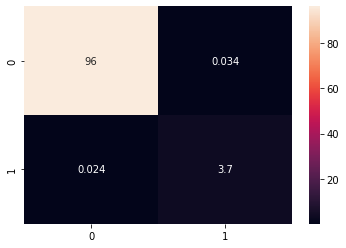

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(x_test1.Target,x_test1.CLASS)
sns.heatmap(cm/len(x_test1.CLASS)*100,annot=True)


# On Faker Data

In [ ]:
pip install Faker

In [ ]:
import pandas as pd
from faker import Faker
fake = Faker(42)

In [ ]:
def data_creation(entries):
    given_name = []
    surname = []
    street_number=[]
    address_1=[]
    address_2=[]
    suburb=[]
    state = []
    postcode = []
    date_of_birth = []
    soc_sec_id = []
    
    for q in range(entries):
        given_name.append(fake.first_name())
        surname.append(fake.last_name())
        street_number.append(fake.building_number())
        address_1.append(fake.street_suffix())
        address_2.append(fake.street_name())
        suburb.append(fake.city())
        state.append(fake.state())
        postcode.append(fake.zipcode())
        soc_sec_id.append(fake.ssn())
        date_of_birth.append(fake.date_of_birth())
        
    df = pd.DataFrame(list(zip(given_name, surname, street_number, address_1, address_2, suburb,  postcode,state,date_of_birth,soc_sec_id)), 
                      columns= ['given_name', 'surname', 'street_number', 'address_1', 'address_2', 'suburb','postcode', 'state','date_of_birth','soc_sec_id'])
    return df

In [ ]:
data_sample=data_creation(entries=10000)

In [ ]:
dfA1=data_sample
dfB1=data_sample
dfA1["phonetic_given_name"] = phonetic(dfA1["given_name"], "soundex")
dfB1["phonetic_given_name"] = phonetic(dfB1["given_name"], "soundex")
dfA1["phonetic_surname"] = phonetic(dfA1["surname"], "soundex")
dfB1["phonetic_surname"] = phonetic(dfB1["surname"], "soundex")
dfA1["initials"] = (dfA1["given_name"].str[0]  + dfA1["surname"].str[0])
dfB1["initials"] = (dfB1["given_name"].str[0]  + dfB1["surname"].str[0])

dfA1["date_of_birth"] = dfA1["date_of_birth"].astype(str).str.replace('-', "")
dfB1["date_of_birth"] = dfB1["date_of_birth"].astype(str).str.replace('-', "")
dfA1["soc_sec_id"] = dfA1["soc_sec_id"].astype(str).str.replace('-', "")
dfB1["soc_sec_id"] = dfB1["soc_sec_id"].astype(str).str.replace('-', "")

dfA1['address']=dfA1['street_number']+" "+dfA1['address_1']+" "+dfA1['address_2']
dfB1['address']=dfB1['street_number']+" "+dfB1['address_1']+" "+dfB1['address_2']

features1=data1(dfA1,dfB1,"initials")

In [ ]:
L_fake = applier.apply(df=features1)

sol=label_model.predict(L_fake)

fake=features1.copy()
fake['CLASS']=sol



100%|██████████| 521312/521312 [00:42<00:00, 12219.32it/s]


In [ ]:

fake.reset_index(inplace=True)
fake=fake[fake["level_0"]!=fake["level_1"]]
fake['CLASS'].value_counts()

0    511238
1        74
Name: CLASS, dtype: int64

In [ ]:
show=fake.loc[(fake.CLASS==1)]
show['Score']= show.iloc[:, 2:11].sum(axis=1)
show.sort_values(by=['Score'],ascending=False, inplace=True)
show.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,level_0,level_1,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address,soc_sec_id,date_of_birth,CLASS,Score
53749,931,6182,1,1,1.000000,1.0,0.376889,0.000000,0.166812,0.083333,0.777778,1,5.404812
61008,6182,931,1,1,1.000000,1.0,0.376889,0.000000,0.166812,0.083333,0.777778,1,5.404812
117351,9606,8483,1,1,0.933333,1.0,0.000000,0.111111,0.082061,0.091287,0.777778,1,4.995570
115943,8483,9606,1,1,0.933333,1.0,0.000000,0.111111,0.082061,0.091287,0.777778,1,4.995570
197712,8011,238,1,1,1.000000,1.0,0.050000,0.000000,0.153960,0.000000,0.786796,1,4.990756


In [ ]:
for i in range(0,10,2):
  display(dfA1.iloc[[show['level_0'].values[i],show['level_1'].values[i]]])

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials,address
931,Michael,Matthews,7378,Mill,Ryan Springs,Port Kerrymouth,06178,Georgia,19070610,344023027,M240,M320,MM,7378 Mill Ryan Springs
6182,Michael,Matthews,739,Oval,Jessica Lakes,Heidimouth,07201,Rhode Island,19270610,311170382,M240,M320,MM,739 Oval Jessica Lakes


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials,address
9606,Andrew,Smith,894,Shoal,Luna Shore,Kimberlybury,15712,Virginia,19980326,358698486,A536,S530,AS,894 Shoal Luna Shore
8483,Andrea,Smith,510,Park,Roger Spring,East Michaelfort,47674,Nebraska,19960326,396557970,A536,S530,AS,510 Park Roger Spring


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials,address
8011,Robert,Smith,332,Dale,Jonathan Corner,Jenniferhaven,59440,Wisconsin,19151119,039782524,R163,S530,RS,332 Dale Jonathan Corner
238,Robert,Smith,4594,Parkway,Daniel Mall,South Petermouth,74716,New Jersey,19111115,654613512,R163,S530,RS,4594 Parkway Daniel Mall


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials,address
2478,Kimberly,White,353,Ford,Robert Viaduct,Jacksonside,80588,New Hampshire,19120111,436118293,K516,W300,KW,353 Ford Robert Viaduct
4294,Kimberly,White,293,Station,Eugene Path,East Ericabury,22379,Rhode Island,19110711,700062152,K516,W300,KW,293 Station Eugene Path


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials,address
3490,Christine,Miller,233,Junctions,Harris Mission,Leblancton,55213,New York,19470109,368044564,C623,M460,CM,233 Junctions Harris Mission
8314,Christopher,Mccann,560,Orchard,Harris Mission,East Justin,64706,Iowa,19710118,323732304,C623,M250,CM,560 Orchard Harris Mission
